In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
batch_size = 64  
epochs = 10 
latent_dim = 256  
num_samples = 10000 
data_path = "deu.txt"

In [3]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 83
Max sequence length for inputs: 15
Max sequence length for outputs: 51


In [4]:
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [5]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s")

Epoch 1/10
125/125 [==============================] - 36s 267ms/step - loss: 1.2920 - accuracy: 0.6898 - val_loss: 1.2050 - val_accuracy: 0.6787
Epoch 2/10
125/125 [==============================] - 30s 241ms/step - loss: 0.8926 - accuracy: 0.7627 - val_loss: 0.9250 - val_accuracy: 0.7512
Epoch 3/10
125/125 [==============================] - 30s 243ms/step - loss: 0.7260 - accuracy: 0.8009 - val_loss: 0.8284 - val_accuracy: 0.7655
Epoch 4/10
125/125 [==============================] - 30s 238ms/step - loss: 0.6356 - accuracy: 0.8202 - val_loss: 0.7577 - val_accuracy: 0.7848
Epoch 5/10
125/125 [==============================] - 29s 236ms/step - loss: 0.5799 - accuracy: 0.8337 - val_loss: 0.7171 - val_accuracy: 0.7941
Epoch 6/10
125/125 [==============================] - 29s 236ms/step - loss: 0.5399 - accuracy: 0.8441 - val_loss: 0.6758 - val_accuracy: 0.8051
Epoch 7/10
125/125 [==============================] - 29s 236ms/step - loss: 0.5082 - accuracy: 0.8530 - val_loss: 0.6435 - val_ac

INFO:tensorflow:Assets written to: s2s\assets


INFO:tensorflow:Assets written to: s2s\assets


In [6]:
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

  
    target_seq = np.zeros((1, 1, num_decoder_tokens))
   
    target_seq[0, 0, target_token_index["\t"]] = 1.0


    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)


        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

   
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True


        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0


        states_value = [h, c]
    return decoded_sentence

In [7]:
for seq_index in range(20):

    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Verschlien Sie dich!

-
Input sentence: Hi.
Decoded sentence: Lass mich nicht!

-
Input sentence: Hi.
Decoded sentence: Lass mich nicht!

-
Input sentence: Run!
Decoded sentence: Verschlien Sie dich!

-
Input sentence: Run.
Decoded sentence: Versicht es mich!

-
Input sentence: Wow!
Decoded sentence: Warten Sie eine Tom!

-
Input sentence: Wow!
Decoded sentence: Warten Sie eine Tom!

-
Input sentence: Duck!
Decoded sentence: Verstinden Sie dich!

-
Input sentence: Fire!
Decoded sentence: Verstinden Sie dich mir an!

-
Input sentence: Help!
Decoded sentence: Behalt mich!

-
Input sentence: Help!
Decoded sentence: Behalt mich!

-
Input sentence: Stay.
Decoded sentence: Verstinden Sie dich mir an!

-
Input sentence: Stop!
Decoded sentence: Verschwinden!

-
Input sentence: Stop!
Decoded sentence: Verschwinden!

-
Input sentence: Wait!
Decoded sentence: Warte mir!

-
Input sentence: Wait.
Decoded sentence: Warte mar!

-
Input sentence: Begin.
Decoded 

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import initializers

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1000)

In [6]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape[0], 'train samples')
print('image shape', x_train[0].shape)

4431872/4422102 [==============================] - 2s 0us/step
60000 train samples
image shape (28, 28)


In [7]:
input_dim = 784
x_train = x_train.reshape(60000, input_dim)
print('input shape: ', x_train.shape[1])
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

input shape:  784


In [8]:
optim = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [9]:
def build_discriminator():
    model =  keras.Sequential()
    model.add(layers.Dense(1024, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
        
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
        
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [10]:
latent_dim = 100

def build_generator():
    model =  keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Dense(input_dim, activation='tanh'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [11]:
discriminator = build_discriminator()
generator = build_generator()

discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = keras.Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optim) 

In [12]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise).reshape(num_of_images, 28, 28)
    plt.figure()
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i], cmap = 'gray')
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [13]:
discrim_losses = []

def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
            
            
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9  
            
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        if ep % 20 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, generator)

epoch:  0


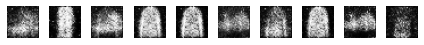

epoch:  20


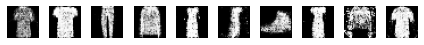

epoch:  40


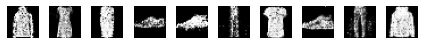

epoch:  60


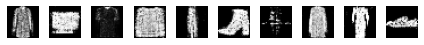

epoch:  80


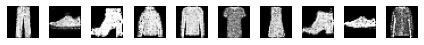

epoch:  100


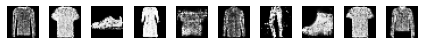

In [14]:
epochs = 100
batch_size = 128
train_model(epochs, batch_size)